In [115]:
import pandas as pd
import numpy as np
import matplotlib as mp
import re
from scipy.spatial import distance
from sklearn.neighbors import KNeighborsClassifier as knn_classifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors



# **Loading and Preprocessing**

**Loading Datasets and StopWords**


In [116]:
train_data = pd.read_csv('/content/drive/My Drive/ass1/train.csv')
test_data = pd.read_csv('/content/drive/My Drive/ass1/test.csv')
train_data = list(zip(train_data['Sentiment'],train_data['Tweet']))
test_data = list(zip(test_data['Sentiment'],test_data['Tweet']))
swords = []
with open ('/content/drive/My Drive/ass1/stop_words.txt','r') as stop_words:
  for x in stop_words:
    swords.append(x.replace("\n",""))

**PreProcessing**

In [117]:
def preprocessing(data):
  inter_lst = []
  for i,tup in enumerate(data):
    #lower case
    subject = data[i][1].lower()
    #replace - with " "
    subject = subject.replace('-',' ')
    #removing everything tweet body containing only words
    for j in subject.split():
      z= re.match(r'[a-z]+',j) #((\@|\#)([a-z0-9]+)|([a-z]+))
      if z and len(z.group())!=0 and z.group() not in swords and len(z.group()) > 3: #accept only those strings which are not empty, str length > 3 and not an element of stopwords list
        y = z.group()
        inter_lst.append(y)
    data[i]= (data[i][0],inter_lst)  
    inter_lst=[]            
  return data
filtered_train_data = preprocessing(train_data)
filtered_test_data = preprocessing(test_data)


**Metadata**


In [118]:
#vocab 
def get_train_vocab(data):
  vocab = []
  for i in data:
    for j in i[1]:
      if j not in vocab:
        vocab.append(j)
  return vocab

def remove_unit_count(data,vocab):
  #flattening all the train data
  complete_text = []
  for i in data:
    for word in i[1]:
      complete_text.append(word)

  #remove all the words with 50 or lesser counts as this step increases the accuracy to almost 10%
  
  counts = 50
  filter = []
  for word in vocab:
    if complete_text.count(word) <= counts:
      filter.append(word)
  return [v for v in vocab if v not in filter]

train_vocab = remove_unit_count(filtered_train_data,get_train_vocab(filtered_train_data))
len(train_vocab) - 1

309

**Vocab to indexed Dictionary**

In [119]:
def vocab_to_dict(vocab):
  vocab_dict = {}
  #removing an empty index
  if "" in vocab:
    vocab.remove("")
  for i,word in enumerate(vocab):
    vocab_dict[i] = word
  return vocab_dict 
vocab_dict = vocab_to_dict(train_vocab)

**Training and Testing Labels**

In [120]:
training_labels = []
testing_labels = []
predicted_labels = []
for tup in filtered_train_data:
  training_labels.append(tup[0])

for tup in filtered_test_data:
  testing_labels.append(tup[0])

**Bag of Words**

In [121]:
def create_feature_vectors(data):
  featured_vector=[]
  inter_vector = []
  for tup in data:
    for word in vocab_dict.values():   # getting counts for each vocab word in the tweet
      inter_vector.append(tup[1].count(word))
    featured_vector.append(inter_vector)
    inter_vector=[]
  return featured_vector

train_vector = create_feature_vectors(filtered_train_data)
test_vector  = create_feature_vectors(filtered_test_data)

# **Part1**


**Calculate Distance**

In [ ]:
distances = distance.cdist(test_vector,train_vector,'euclidean')
distances = np.array(distances)

**K-Neighbors**

In [ ]:
#sorting distances to get the indices of the array
sorted_distances = np.argsort(np.array(distances),axis = 1) 

def select_k(k,vec):
  categories = ['positive','negative','neutral']
  labels = []
  labels_dict={}
  if k == 1:
    return {training_labels[vec[0]]:1}
  for i in range(0,k):
    labels.append(training_labels[vec[i]])
  for i in categories:
    labels_dict[i] = labels.count(i)
  if len(labels_dict.values()) != len(set(labels_dict.values())): # if multiple labels have same count recursively call with k-1 until no tie or k=1
    return select_k(k-1,vec)
  else:
    return labels_dict

def get_max(labels_dict):
  keys = list(labels_dict.keys())
  if len(keys) == 1:
    return keys[0]
  values = list(labels_dict.values())
  return keys[values.index(max(values))]
  

**Predicting Labels**

In [ ]:
values_for_k = [1,3,5,7,10]
def get_predicted_labels(k):
  predicted_labels = []
  for row in sorted_distances:
    predicted_labels.append(get_max(select_k(k,row))) # get the max count label
  return predicted_labels

predicted_labels = {}
for i in values_for_k:
  predicted_labels[i] = get_predicted_labels(i)


**Performance Metrics**

In [ ]:
def get_accuracy_for_k(k):
  predicted = predicted_labels[k]
  trues = 0
  for i in range(0,len(predicted)):
    if predicted[i] == testing_labels[i]: #accuracy true_predicted/all_labels
      trues +=1
  return trues/len(testing_labels) 

accuracy = {}
for i in values_for_k:
  accuracy[i] = get_accuracy_for_k(i)

print(accuracy)


{1: 0.5847312564190346, 3: 0.6196508045190003, 5: 0.6254707292023279, 7: 0.6278671687778158, 10: 0.6340294419719275} 2921


In [ ]:
def get_confusion_matrix(k):
  predicted = predicted_labels[k]
  confusion_matrix = np.zeros((3,3))
  labels = ['positive','negative','neutral']
  #filling diagonal entries
  confusion_matrix[0][0] = len([i for i in range(0,len(predicted)) if predicted[i] == 'positive' and testing_labels[i] == 'positive'])
  confusion_matrix[1][1] = len([i for i in range(0,len(predicted)) if predicted[i] == 'negative' and testing_labels[i] == 'negative'])
  confusion_matrix[2][2] = len([i for i in range(0,len(predicted)) if predicted[i] == 'neutral' and testing_labels[i] == 'neutral'])
  #filling remaining entries for positive
  confusion_matrix[0][1] = len([i for i in range(0,len(predicted)) if predicted[i] == 'positive' and testing_labels[i] == 'negative'])
  confusion_matrix[0][2] = len([i for i in range(0,len(predicted)) if predicted[i] == 'positive' and testing_labels[i] == 'neutral'])
  #filling remaining entries for negative
  confusion_matrix[1][0] = len([i for i in range(0,len(predicted)) if predicted[i] == 'negative' and testing_labels[i] == 'positive'])
  confusion_matrix[1][2] = len([i for i in range(0,len(predicted)) if predicted[i] == 'negative' and testing_labels[i] == 'neutral'])
  #filling remaining entries for neutral
  confusion_matrix[2][0] = len([i for i in range(0,len(predicted)) if predicted[i] == 'neutral' and testing_labels[i] == 'positive'])
  confusion_matrix[2][1] = len([i for i in range(0,len(predicted)) if predicted[i] == 'neutral' and testing_labels[i] == 'negative'])
  return confusion_matrix

print('positive,negative,neutral')
for i in [1,3,5,7,10]:
  print('confusion matrix for k = ',i)
  print('label sequence :positive,negative,neutral')
  print(get_confusion_matrix(i))
  print('\n')


positive,negative,neutral
confusion matrix for k =  1
label sequence :positive,negative,neutral
[[ 247.  184.  108.]
 [ 106. 1117.  163.]
 [ 119.  533.  344.]]


confusion matrix for k =  3
label sequence :positive,negative,neutral
[[ 261.  146.   90.]
 [  85. 1177.  153.]
 [ 126.  511.  372.]]


confusion matrix for k =  5
label sequence :positive,negative,neutral
[[ 263.  149.   86.]
 [  85. 1183.  148.]
 [ 124.  502.  381.]]


confusion matrix for k =  7
label sequence :positive,negative,neutral
[[ 263.  119.   73.]
 [  88. 1195.  166.]
 [ 121.  520.  376.]]


confusion matrix for k =  10
label sequence :positive,negative,neutral
[[ 258.  104.   67.]
 [  86. 1199.  153.]
 [ 128.  531.  395.]]




In [ ]:
def get_macro_precision_n_recall_n_f1(k):
  confusion_matrix = get_confusion_matrix(k)
  
  #getting precisions for all classes
  prec_pos = confusion_matrix[0][0]/np.sum(confusion_matrix[0])
  prec_neg = confusion_matrix[1][1]/np.sum(confusion_matrix[1])
  prec_neu = confusion_matrix[2][2]/np.sum(confusion_matrix[2])
  
  
  #getting recalls for all classes
  recal_pos = confusion_matrix[0][0]/np.sum(confusion_matrix,axis=0)[0]
  recal_neg = confusion_matrix[1][1]/np.sum(confusion_matrix,axis=0)[1]
  recal_neu = confusion_matrix[2][2]/np.sum(confusion_matrix,axis=0)[2]

  #getting f1s for all classes
  f1_pos =  2 * (prec_pos * recal_pos)/(prec_pos + recal_pos)
  f1_neg =  2 * (prec_neg * recal_neg)/(prec_neg + recal_neg)
  f1_neu =  2 * (prec_neu * recal_neu)/(prec_neu + recal_neu)

  #return macro avg and accuracy
  return [(f1_pos+f1_neg+f1_neu)/3, (prec_pos + prec_neg + prec_neu)/3,(recal_pos + recal_neg + recal_neu)/3,get_accuracy_for_k(k)] 



scores = {}
for i in values_for_k:
  print('F1-score,Precison,Recall,Accurracy')
  print('Macro-avged stats for k=',i)
  scores[i] = get_macro_precision_n_recall_n_f1(i)
  print(scores[i])
  print('\n') 

sorted_scores = {}
sorted_scores['accuracy'] =[scores[i][3] for i in scores.keys()]
sorted_scores['f1-score'] = [scores[i][0] for i in scores.keys()]
sorted_scores['precision'] = [scores[i][1] for i in scores.keys()]
sorted_scores['recall'] = [scores[i][2] for i in scores.keys()]


F1-score,Precison,Recall,Accurracy
Macro-avged stats for k= 1
[0.5364926263198535, 0.5365179539017749, 0.5639019774437066, 0.5847312564190346]


F1-score,Precison,Recall,Accurracy
Macro-avged stats for k= 3
[0.5737861313426146, 0.57521162960162, 0.5998702602638839, 0.6196508045190003]


F1-score,Precison,Recall,Accurracy
Macro-avged stats for k= 5
[0.580019474493752, 0.5806386554752496, 0.6072512509637971, 0.6254707292023279]


F1-score,Precison,Recall,Accurracy
Macro-avged stats for k= 7
[0.5853995980204703, 0.5908145066282812, 0.6067222489453145, 0.6278671687778158]


F1-score,Precison,Recall,Accurracy
Macro-avged stats for k= 10
[0.5929731388817895, 0.6033194499808208, 0.6142162868406127, 0.6340294419719275]




**Performance Plots**

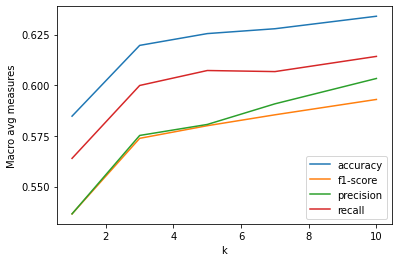

In [ ]:
k = [1,3,5,7,10]
plt.plot(k,sorted_scores['accuracy'],label='accuracy')
plt.plot(k,sorted_scores['f1-score'],label='f1-score')
plt.plot(k,sorted_scores['precision'],label='precision')   # plotting each curve with label
plt.plot(k,sorted_scores['recall'],label='recall')
plt.locator_params(nbins=5) # adjusting bins to match len(k). no idea y its not working.
plt.xlabel('k')
plt.ylabel('Macro avg measures')
plt.legend()
plt.show()


#**Part2**

**KNN Using Sklearn**

In [ ]:
#a factory function to generate models with given k
def model_maker(k):
  model = knn_classifier(n_neighbors=k,algorithm='brute')
  model.fit(np.array(train_vector),np.array(training_labels))
  return model

In [ ]:
def predictor():
  predictions={}
  k = [1,3,5,7,10]
  for i in k:
    model = model_maker(i)
    predictions[i] = model.predict(np.array(test_vector)) # predicting all tweets for each k
  return predictions

predictions = predictor()

**Performance Metrics**

In [ ]:
def get_accuracy():
  accuracy = {}
  for i in predictions.keys():
    accuracy[i] = accuracy_score(np.array(testing_labels),predictions[i])
  return accuracy
accuracy = get_accuracy()

In [ ]:
stats = {}
def get_report():
  for i in predictions.keys():
    print("Classification Report for k=",i)
    print(classification_report(np.array(testing_labels),predictions[i],labels=['negative','positive','neutral']))
get_report()

Classification Report for k= 1
              precision    recall  f1-score   support

    negative       0.79      0.60      0.68      1834
    positive       0.47      0.49      0.48       472
     neutral       0.35      0.59      0.44       615

    accuracy                           0.58      2921
   macro avg       0.54      0.56      0.53      2921
weighted avg       0.65      0.58      0.60      2921

Classification Report for k= 3
              precision    recall  f1-score   support

    negative       0.79      0.69      0.74      1834
    positive       0.59      0.55      0.57       472
     neutral       0.39      0.55      0.45       615

    accuracy                           0.64      2921
   macro avg       0.59      0.60      0.59      2921
weighted avg       0.67      0.64      0.65      2921

Classification Report for k= 5
              precision    recall  f1-score   support

    negative       0.76      0.73      0.74      1834
    positive       0.64      0.52   

In [ ]:
def get_confusion_mat():
  for i in predictions.keys():
    print("Confusion Matrix for k=",i)
    print(confusion_matrix(np.array(testing_labels),predictions[i],labels=['negative','positive','neutral']))
get_confusion_mat()

Confusion Matrix for k= 1
[[1103  172  559]
 [ 121  231  120]
 [ 166   88  361]]
Confusion Matrix for k= 3
[[1267  113  454]
 [ 124  258   90]
 [ 208   66  341]]
Confusion Matrix for k= 5
[[1338   82  414]
 [ 135  244   93]
 [ 289   53  273]]
Confusion Matrix for k= 7
[[1354   89  391]
 [ 122  237  113]
 [ 283   52  280]]
Confusion Matrix for k= 10
[[1375   83  376]
 [ 125  249   98]
 [ 266   59  290]]


**Performance Plots**

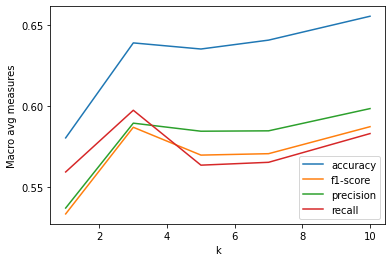

In [ ]:
#getting all stats in a grouped form
def get_stats():
  stats= []
  stats_dict={}
  k = [1,3,5,7,10]
  for i in k:
    x = classification_report(np.array(testing_labels),predictions[i],output_dict = True)
    stats.append([x['accuracy'],x['macro avg']['f1-score'],x['macro avg']['precision'],x['macro avg']['recall']])
  stats_dict['accuracy'] = [i[0] for i in stats]
  stats_dict['f1-score'] = [i[1] for i in stats]
  stats_dict['precision'] = [i[2] for i in stats]
  stats_dict['recall'] = [i[3] for i in stats]

  return stats_dict

def plot():
  k = [1,3,5,7,10]
  stats = get_stats()
  plt.plot(k,stats['accuracy'],label='accuracy')
  plt.plot(k,stats['f1-score'],label='f1-score')
  plt.plot(k,stats['precision'],label='precision')
  plt.plot(k,stats['recall'],label='recall')
  plt.locator_params(nbins=5)
  plt.xlabel('k')
  plt.ylabel('Macro avg measures')
  plt.legend()
  
plot()

#**Part3**

**Loading pre-trained Vectors**


In [122]:
word2vec = KeyedVectors.load_word2vec_format("/content/drive/My Drive/ass1/GoogleNews-vectors-negative300.bin.gz", binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


**Extracting features**

In [123]:
from tqdm import tqdm #library to prompt progress
def extract_features(data):
  final_vector = []
  for tup in tqdm(data):
    x = [word for word in tup[1] if word in word2vec.vocab]
    if not x:
      final_vector.append(np.zeros(300))
    else:
      final_vector.append(np.mean(word2vec[x],axis=0)) #averaging over all words along x axis to get a consistent 300 dimensional vector for each tweet
  return np.array(final_vector)

train_vector2 = extract_features(filtered_train_data).reshape(len(filtered_train_data),300)
test_vector2  = extract_features(filtered_test_data).reshape(len(filtered_test_data),300)

100%|██████████| 2921/2921 [00:00<00:00, 16496.95it/s]


**PART1 Implementation**

In [124]:
#calculating and sorting euclidean distances
distances = distance.cdist(np.array(test_vector2),np.array(train_vector2),'euclidean')
sorted_distances = np.argsort(np.array(distances),axis = 1) 

In [125]:
#get predicted labels for each k
values_for_k = [1,3,5,7,10]
predicted_labels = {}
for i in values_for_k:
  predicted_labels[i] = get_predicted_labels(i)

In [127]:
#confusion matrix
print('positive,negative,neutral')
for i in [1,3,5,7,10]:
  print('confusion matrix for k = ',i)
  print('label sequence :positive,negative,neutral')
  print(get_confusion_matrix(i))
  print('\n')

positive,negative,neutral
confusion matrix for k =  1
label sequence :positive,negative,neutral
[[ 260.  120.   90.]
 [ 123. 1536.  262.]
 [  89.  178.  263.]]


confusion matrix for k =  3
label sequence :positive,negative,neutral
[[ 258.   68.   69.]
 [ 151. 1661.  322.]
 [  63.  105.  224.]]


confusion matrix for k =  5
label sequence :positive,negative,neutral
[[ 258.   54.   64.]
 [ 164. 1698.  345.]
 [  50.   82.  206.]]


confusion matrix for k =  7
label sequence :positive,negative,neutral
[[ 252.   40.   50.]
 [ 184. 1739.  374.]
 [  36.   55.  191.]]


confusion matrix for k =  10
label sequence :positive,negative,neutral
[[ 255.   36.   45.]
 [ 184. 1761.  398.]
 [  33.   37.  172.]]




In [129]:
scores = {}
for i in values_for_k:
  print('F1-score,Precison,Recall,Accurracy')
  print('Macro-avged stats for k=',i)
  scores[i] = get_macro_precision_n_recall_n_f1(i)
  print(scores[i])
  print('\n') 

sorted_scores = {}
sorted_scores['accuracy'] =[scores[i][3] for i in scores.keys()]
sorted_scores['f1-score'] = [scores[i][0] for i in scores.keys()]
sorted_scores['precision'] = [scores[i][1] for i in scores.keys()]
sorted_scores['recall'] = [scores[i][2] for i in scores.keys()]

F1-score,Precison,Recall,Accurracy
Macro-avged stats for k= 1
[0.6098382730586269, 0.6163338182300983, 0.6053344551522146, 0.7048955837042109]


F1-score,Precison,Recall,Accurracy
Macro-avged stats for k= 3
[0.6257463631306309, 0.6676478812848381, 0.6055028256601994, 0.733652858610065]


F1-score,Precison,Recall,Accurracy
Macro-avged stats for k= 5
[0.6270652005837197, 0.6883359513866004, 0.6024715554347381, 0.7401574803149606]


F1-score,Precison,Recall,Accurracy
Macro-avged stats for k= 7
[0.6289851681534925, 0.7237405049101108, 0.5975560216944423, 0.7470044505306402]


F1-score,Precison,Recall,Accurracy
Macro-avged stats for k= 10
[0.6252590812443561, 0.7404242950817855, 0.5933751087644881, 0.749058541595344]




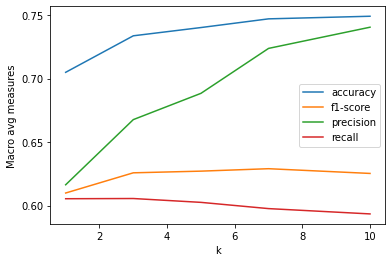

In [130]:
k = [1,3,5,7,10]
plt.plot(k,sorted_scores['accuracy'],label='accuracy')
plt.plot(k,sorted_scores['f1-score'],label='f1-score')
plt.plot(k,sorted_scores['precision'],label='precision')
plt.plot(k,sorted_scores['recall'],label='recall')
plt.locator_params(nbins=5)
plt.xlabel('k')
plt.ylabel('Macro avg measures')
plt.legend()
plt.show()

**PART2 Implementation**

In [ ]:
def model_maker(k):
  model = knn_classifier(n_neighbors=k,algorithm='brute')
  model.fit(np.array(train_vector2),np.array(training_labels))
  return model

In [ ]:
def predictor():
  predictions={}
  k = [1,3,5,7,10]
  for i in k:
    model = model_maker(i)
    predictions[i] = model.predict(np.array(test_vector2))
  return predictions

predictions = predictor()

In [ ]:
get_report()

In [ ]:
get_confusion_mat()

In [ ]:
plot()